In [157]:
import pickle
import numpy as np
import time
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from KB_evolution_utils import logmodel, custom_tokens_bow, inverse_document_frequency, term_frequency, split, acc_score

In [6]:
amazon = pd.read_csv("dataset/amazon.csv")
amazon

frame = amazon.copy()

"""*Difference between a stemmed and lemmatized words*"""

X_bow, features = custom_tokens_bow(frame.cmd)
all_terms = list(features)
y_score = frame.score

idf = inverse_document_frequency(X_bow)
tf_sent, tf_terms = term_frequency(X_bow)


X_train, X_test, Y_train, Y_test = split(X_bow, y_score)

"""### Compare models without GA"""
all_models_score_table = acc_score(X_bow, y_score)
all_models_score_table

Total Vocab Count: 1566


,Classifier,Accuracy,Exec_Time_secs
0,DecisionTree,0.808,0.372023
1,RandomForest,0.800,1.962792
2,MultinomialNB,0.796,0.009973
3,LinearSVM,0.776,0.661252
4,Logistic,0.776,0.077812
5,RadialSVM,0.756,0.850302
6,KNeighbors,0.660,0.000993


In [7]:
def predicted_sentiment_ratio(y_test, predictions):
    positive_percent = np.count_nonzero(predictions==1)*100//len(predictions)
    negative_percent = np.count_nonzero(predictions==0)*100//len(predictions)
    # print(f"Y_test: pos/neg percentage ~ {np.count_nonzero(y_test==1)*100//len(y_test)}, {np.count_nonzero(y_test==0)*100//len(y_test)}")
    return positive_percent, negative_percent

In [8]:
def test_accuracy(selected_genes):
    st = time.time()

    # to be corrected   
    logmodel.fit(X_train[:, selected_genes], Y_train)
    
    et = time.time()

    predictions = logmodel.predict(X_test[:, selected_genes])
    ratio = predicted_sentiment_ratio(Y_test, predictions)
    return accuracy_score(Y_test, predictions), et-st, ratio

In [152]:
def get_intersection_genes(result_set):
    size_of_chromo = None
    common_indexes = {}
    best_chromo_in_each_run = []
    for res in result_set:
        best_chromo = res[0][-1]   
        size_of_chromo = len(best_chromo)
        chromo_features = np.where(best_chromo != 0)[0]
        best_chromo_in_each_run.append([best_chromo, chromo_features.shape[0], res[1][-1]])

        for index in chromo_features:
            common_indexes[index] = common_indexes.setdefault(index, 0) + 1
            
    sorted_common_indexes = np.array(sorted(common_indexes.items(), key=lambda x: x[1], reverse=True))
    
    return sorted_common_indexes, best_chromo_in_each_run

In [189]:
def accuracy_plot(table):
    table_df = pd.DataFrame(table)
    sns.lineplot(x='Accuracy', y='value', 
             data=pd.melt(table_df, ['Accuracy']))
    

# Collect Common indexes from res of n run evolution


# Final Results

In [144]:
def tabulate_results(chromo_set):
    print('Actual chromosome length in X_Test: ', X_bow.shape[1])
    print('\nRandomForest with full length -', all_models_score_table.iloc[0, 1:], "\n")
    # print('Total Common genes count ~(-1): ', top_i_common_indexes)

    accuracy = []
    features_count = []
    time_to_train = []
    sentiment_ratio = []

    sorted_common_indexes, best_chromo_in_each_run = get_intersection_genes(chromo_set)
    common_indexes_count = sorted_common_indexes[:, 1]
    # print("Total common indexes:", sorted_common_indexes.shape[0])

    count_thresholds = list(set(common_indexes_count))[::-1]
    print("Intersection frequency:", count_thresholds, "\n")

    for i in count_thresholds:
        selected_features  = sorted_common_indexes[np.where(sorted_common_indexes[:, 1] >= i), 0][0]
        features_count.append(len(selected_features))
        acc, ttt, sr = test_accuracy(selected_features)
        accuracy.append(acc)
        time_to_train.append(ttt)
        sentiment_ratio.append(sr)

    
    table_data = {'Count Threshold': count_thresholds,
                'Feature count': features_count,
                'Accuracy': accuracy,
                'Time Taken to Train': time_to_train,
                'Sentiment Ratio(p/n)': sentiment_ratio
                }
    print(tabulate(table_data, headers='keys', tablefmt="simple_grid"))
    return table_data, best_chromo_in_each_run


TypeError: Invalid object type at position 78

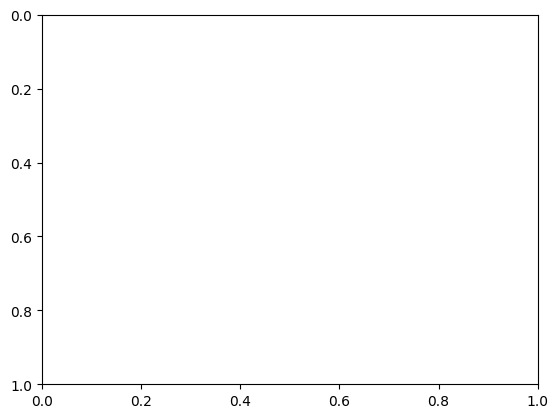

In [190]:
accuracy_plot(n_run_kb_co_table)

In [167]:
with open('pickles/kbga/amazon/n_run_az_kb_co.pkl', 'rb') as rf:
    n_kb_co = pickle.load(rf)
    n_run_kb_co_table, best_chromos_co = tabulate_results(n_kb_co)
    n_run_kb_co_table

Actual chromosome length in X_Test:  1566

RandomForest with full length - Accuracy             0.808
Exec_Time_secs    0.372023
Name: 0, dtype: object 

Intersection frequency: [30, 29, 25, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1] 

┌───────────────────┬─────────────────┬────────────┬───────────────────────┬────────────────────────┐
│   Count Threshold │   Feature count │   Accuracy │   Time Taken to Train │ Sentiment Ratio(p/n)   │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│                30 │               3 │      0.484 │              0.342084 │ (0, 100)               │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│                29 │               4 │      0.488 │              0.312164 │ (0, 99)                │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│         

In [170]:
best_chromos_co

[[array([0, 1, 1, ..., 0, 0, 0]), 438, 0.856],
 [array([0, 0, 0, ..., 0, 0, 0]), 423, 0.848],
 [array([0, 0, 1, ..., 0, 0, 0]), 347, 0.852],
 [array([0, 1, 0, ..., 0, 0, 0]), 455, 0.844],
 [array([0, 0, 0, ..., 0, 0, 0]), 475, 0.856],
 [array([0, 0, 1, ..., 0, 0, 0]), 558, 0.844],
 [array([0, 0, 0, ..., 0, 0, 0]), 400, 0.832],
 [array([0, 0, 0, ..., 0, 1, 0]), 423, 0.836],
 [array([0, 0, 0, ..., 0, 1, 1]), 503, 0.864],
 [array([0, 0, 1, ..., 0, 0, 0]), 437, 0.844],
 [array([0, 0, 0, ..., 0, 0, 1]), 308, 0.824],
 [array([0, 0, 0, ..., 0, 0, 0]), 431, 0.836],
 [array([0, 0, 1, ..., 0, 0, 1]), 509, 0.828],
 [array([0, 0, 0, ..., 1, 0, 1]), 396, 0.844],
 [array([0, 0, 0, ..., 1, 0, 0]), 443, 0.852],
 [array([1, 0, 1, ..., 0, 1, 0]), 312, 0.828],
 [array([1, 0, 0, ..., 0, 0, 0]), 366, 0.82],
 [array([0, 0, 1, ..., 0, 1, 0]), 292, 0.828],
 [array([0, 0, 0, ..., 0, 1, 0]), 443, 0.864],
 [array([1, 0, 0, ..., 0, 0, 0]), 463, 0.852],
 [array([0, 0, 1, ..., 0, 0, 0]), 472, 0.84],
 [array([0, 0, 

In [161]:
with open('pickles/kbga/amazon/n_run_az_kb_mu.pkl', 'rb') as rf:
    n_kb_mu = pickle.load(rf)
    n_run_kb_mu_table, best_chromos_mu = tabulate_results(n_kb_mu)
    n_run_kb_mu_table

Actual chromosome length in X_Test:  1566

RandomForest with full length - Accuracy             0.808
Exec_Time_secs    0.372023
Name: 0, dtype: object 

Intersection frequency: [30, 27, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 3, 2] 

┌───────────────────┬─────────────────┬────────────┬───────────────────────┬────────────────────────┐
│   Count Threshold │   Feature count │   Accuracy │   Time Taken to Train │ Sentiment Ratio(p/n)   │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│                30 │               3 │      0.484 │              0.640286 │ (0, 100)               │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│                27 │               5 │      0.484 │              0.585433 │ (0, 100)               │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│              

In [162]:
with open('pickles/kbga/amazon/n_run_az_kb_ip.pkl', 'rb') as rf:
    n_kb_ip = pickle.load(rf)
    n_run_kb_ip_table, best_chromos_ip = tabulate_results(n_kb_ip)
    n_run_kb_ip_table

Actual chromosome length in X_Test:  1566

RandomForest with full length - Accuracy             0.808
Exec_Time_secs    0.372023
Name: 0, dtype: object 

Intersection frequency: [30, 29, 28, 27, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1] 

┌───────────────────┬─────────────────┬────────────┬───────────────────────┬────────────────────────┐
│   Count Threshold │   Feature count │   Accuracy │   Time Taken to Train │ Sentiment Ratio(p/n)   │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│                30 │               2 │      0.484 │              0.455779 │ (0, 100)               │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│                29 │               4 │      0.484 │              0.42187  │ (0, 100)               │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│             

In [163]:
with open('pickles/kbga/amazon/n_run_az_kb_ps.pkl', 'rb') as rf:
    n_kb_ps = pickle.load(rf)
    n_run_kb_ps_table, best_chromos_ps = tabulate_results(n_kb_ps)
    n_run_kb_ps_table

Actual chromosome length in X_Test:  1566

RandomForest with full length - Accuracy             0.808
Exec_Time_secs    0.372023
Name: 0, dtype: object 

Intersection frequency: [8, 7, 6, 5, 4, 3, 2, 1] 

┌───────────────────┬─────────────────┬────────────┬───────────────────────┬────────────────────────┐
│   Count Threshold │   Feature count │   Accuracy │   Time Taken to Train │ Sentiment Ratio(p/n)   │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│                 8 │               6 │      0.476 │              0.51564  │ (0, 99)                │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│                 7 │              13 │      0.472 │              0.398932 │ (1, 98)                │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│                 6 │              39 │      0.544 │              0.421872 │ (94,

In [169]:
with open('pickles/kbga/amazon/n_run_az_kbga.pkl', 'rb') as rf:
    n_kbga = pickle.load(rf)
    n_run_kbga_table, best_chromos_kbga = tabulate_results(n_kbga)
    n_run_kbga_table

Actual chromosome length in X_Test:  1566

RandomForest with full length - Accuracy             0.808
Exec_Time_secs    0.372023
Name: 0, dtype: object 

Intersection frequency: [10, 9, 8, 7, 6, 5, 4, 3, 2, 1] 

┌───────────────────┬─────────────────┬────────────┬───────────────────────┬────────────────────────┐
│   Count Threshold │   Feature count │   Accuracy │   Time Taken to Train │ Sentiment Ratio(p/n)   │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│                10 │               2 │      0.484 │              0.4109   │ (0, 100)               │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│                 9 │               7 │      0.484 │              0.390954 │ (0, 100)               │
├───────────────────┼─────────────────┼────────────┼───────────────────────┼────────────────────────┤
│                 8 │              16 │      0.536 │              0.319143